In [157]:
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

import skimage.io
from skimage.transform import resize

import math

In [256]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

# from keras.applications import xception, vgg16, vgg19, mobilenet
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Subtract, Lambda
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.utils import np_utils, multi_gpu_model
from keras.optimizers import SGD, Adam
# from keras.datasets import mnist
from keras import backend as K
# from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

In [5]:
def load_image(path):
    img = skimage.io.imread(path, as_grey=True)
    return img

## Load in the data names and create a train-test split

In [6]:
tr = pd.read_csv('../exploratory_analysis/image_dims.csv')

In [153]:
tr.head()

,Image,Id,x,y,channels
0,0000e88ab.jpg,w_f48451c,700,1050,3
1,0001f9222.jpg,w_c3d896a,325,758,3
2,00029d126.jpg,w_20df2c5,497,1050,3
3,00050a15a.jpg,new_whale,525,1050,3
4,0005c1ef8.jpg,new_whale,525,1050,3


In [154]:
tr['x'].max(), tr['y'].max()

(1575, 1050)

In [9]:
tr = tr[tr['channels']==3]

In [10]:
wcts = tr['Id'].value_counts()

nonew = pd.DataFrame(wcts[1:]).reset_index()
nonew.columns = ['Id', 'cts']

In [11]:
nonew.head()

,Id,cts
0,w_23a388d,73
1,w_9b5109b,65
2,w_9c506f6,62
3,w_0369a5c,61
4,w_700ebb4,57


In [12]:
same = nonew[nonew['cts']>1]['Id'].values
diff = nonew[nonew['cts']==1]['Id'].values

In [259]:
def gen_random_batch(same_groups, diff_groups, batch_halfsize = 8, target_size=(224,224,3)):
    out_img_a, out_img_b, out_score = [], [], []

    same_idx = np.random.choice(same_groups, size = batch_halfsize, replace=True) # need replace=True in case half batch size > number of groups
    diff_idx = np.random.choice(diff_groups, size = batch_halfsize, replace=True)
    
    diff_set = set(diff_groups)
    
    for idx in same_idx:
        curr_images = tr[tr['Id']==idx]['Image'].values
        
        first_image = np.random.choice(curr_images)
        second_image = np.random.choice(list(set(curr_images) - set([first_image])))
        
        first_image = resize(skimage.io.imread('../train/'+first_image), target_size)
        second_image = resize(skimage.io.imread('../train/'+second_image), target_size)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([1, 0])
        
    for idx in diff_idx:
        first_image = tr[tr['Id']==idx]['Image'].values[0]
        
        second_idx = np.random.choice(list(diff_set - set([idx])))
        second_image = tr[tr['Id']==second_idx]['Image'].values[0]
        
        first_image = resize(skimage.io.imread('../train/'+first_image), target_size)
        second_image = resize(skimage.io.imread('../train/'+second_image), target_size)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([0, 1])
        
#     return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

    return np.array(out_img_a), np.array(out_img_b), np.array(out_score)

def gen_random_batch_resize_preserve_AR(same_groups, diff_groups, batch_halfsize = 8, longest_dim=1000):
    out_img_a, out_img_b, out_score = [], [], []

    same_idx = np.random.choice(same_groups, size = batch_halfsize, replace=True) # need replace=True in case half batch size > number of groups
    diff_idx = np.random.choice(diff_groups, size = batch_halfsize, replace=True)
    
    diff_set = set(diff_groups)
    
    for idx in same_idx:
        curr_images = tr[tr['Id']==idx]['Image'].values
        
        first_image = np.random.choice(curr_images)
        second_image = np.random.choice(list(set(curr_images) - set([first_image])))
        
        first_image = resize_w_aspect_ratio(skimage.io.imread('../train/'+first_image), longest_dim)
        second_image = resize_w_aspect_ratio(skimage.io.imread('../train/'+second_image), longest_dim)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([1])
        
    for idx in diff_idx:
        first_image = tr[tr['Id']==idx]['Image'].values[0]
        
        second_idx = np.random.choice(list(diff_set - set([idx])))
        second_image = tr[tr['Id']==second_idx]['Image'].values[0]
        
        first_image = resize_w_aspect_ratio(skimage.io.imread('../train/'+first_image), longest_dim)
        second_image = resize_w_aspect_ratio(skimage.io.imread('../train/'+second_image), longest_dim)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([0])
        
#     return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

    return np.array(out_img_a), np.array(out_img_b), np.array(out_score)

def gen_random_batch_resize_scale(same_groups, diff_groups, batch_halfsize = 8, target_size=(224,224,3)):
    out_img_a, out_img_b, out_score = [], [], []

    same_idx = np.random.choice(same_groups, size = batch_halfsize, replace=True) # need replace=True in case half batch size > number of groups
    diff_idx = np.random.choice(diff_groups, size = batch_halfsize, replace=True)
    
    diff_set = set(diff_groups)
    
    for idx in same_idx:
        curr_images = tr[tr['Id']==idx]['Image'].values
        
        first_image = np.random.choice(curr_images)
        second_image = np.random.choice(list(set(curr_images) - set([first_image])))
        
        first_image = resize(skimage.io.imread('../train/'+first_image), target_size)*255-110
        second_image = resize(skimage.io.imread('../train/'+second_image), target_size)*255-110
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([1, 0])
        
    for idx in diff_idx:
        first_image = tr[tr['Id']==idx]['Image'].values[0]
        
        second_idx = np.random.choice(list(diff_set - set([idx])))
        second_image = tr[tr['Id']==second_idx]['Image'].values[0]
        
        first_image = resize(skimage.io.imread('../train/'+first_image), target_size)*255-110
        second_image = resize(skimage.io.imread('../train/'+second_image), target_size)*255-110
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([0, 1])
        
#     return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

    return np.array(out_img_a), np.array(out_img_b), np.array(out_score)

def gen_random_batch_no_resize(same_groups, diff_groups, batch_halfsize = 8, target_size=(224,224,3)):
    out_img_a, out_img_b, out_score = [], [], []

    same_idx = np.random.choice(same_groups, size = batch_halfsize, replace=True) # need replace=True in case half batch size > number of groups
    diff_idx = np.random.choice(diff_groups, size = batch_halfsize, replace=True)
    
    diff_set = set(diff_groups)
    
    for idx in same_idx:
        curr_images = tr[tr['Id']==idx]['Image'].values
        
        first_image = np.random.choice(curr_images)
        second_image = np.random.choice(list(set(curr_images) - set([first_image])))
        
        first_image = skimage.io.imread('../train/'+first_image)
        second_image = skimage.io.imread('../train/'+second_image)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([1, 0])
        
    for idx in diff_idx:
        first_image = tr[tr['Id']==idx]['Image'].values[0]
        
        second_idx = np.random.choice(list(diff_set - set([idx])))
        second_image = tr[tr['Id']==second_idx]['Image'].values[0]
        
        first_image = skimage.io.imread('../train/'+first_image)
        second_image = skimage.io.imread('../train/'+second_image)
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([0, 1])
        
#     return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)
    return out_img_a, out_img_b, out_score

def gen_random_batch_img_names(same_groups, diff_groups, batch_halfsize = 8, target_size=(224,224,3)):
    out_img_a, out_img_b, out_score = [], [], []

    same_idx = np.random.choice(same_groups, size = batch_halfsize, replace=True) # need replace=True in case half batch size > number of groups
    diff_idx = np.random.choice(diff_groups, size = batch_halfsize, replace=True)
    
    diff_set = set(diff_groups)
    
    for idx in same_idx:
        curr_images = tr[tr['Id']==idx]['Image'].values
        
        first_image = np.random.choice(curr_images)
        second_image = np.random.choice(list(set(curr_images) - set([first_image])))
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([1, 0])
        
    for idx in diff_idx:
        first_image = tr[tr['Id']==idx]['Image'].values[0]
        
        second_idx = np.random.choice(list(diff_set - set([idx])))
        second_image = tr[tr['Id']==second_idx]['Image'].values[0]
        
        out_img_a += [first_image]
        out_img_b += [second_image]
        out_score.append([0, 1])
        
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [245]:
def siam_gen(same_groups, diff_groups, batch_size = 32, image_size=(224,224,3)):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(same_groups, diff_groups, batch_size//2, image_size)
        yield [pv_a, pv_b], pv_sim
        
def siam_gen_resize_scale(same_groups, diff_groups, batch_size = 32, image_size=(224,224,3)):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch_resize_scale(same_groups, diff_groups, batch_size//2, image_size)
        yield [pv_a, pv_b], pv_sim
        
def siam_gen_resize_preserve_AR(same_groups, diff_groups, batch_size = 32, image_size=(224,224,3)):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch_resize_preserve_AR(same_groups, diff_groups, batch_size//2, image_size)
        yield [pv_a, pv_b], pv_sim
        
def siam_gen_no_resize(same_groups, diff_groups, batch_size = 32, image_size=(224,224,3)):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch_no_resize(same_groups, diff_groups, batch_size//2, image_size)
        yield [pv_a, pv_b], pv_sim

In [246]:
same_train, same_val = train_test_split(same, test_size=0.2)
diff_train, diff_val = train_test_split(diff, test_size=0.2)

In [252]:
def biggenate_zero_pad(img, target_size):
    
    img_x, img_y, img_z = img.shape
    tgt_x, tgt_y, tgt_z = target_size
    
    new_image = np.zeros((tgt_x, tgt_y, tgt_z), dtype=np.float64)
    low_x = math.floor((tgt_x-img_x)/2)
    low_y = math.floor((tgt_y-img_y)/2)
    high_x = low_x + img_x
    high_y = low_y + img_y
    
#     print(low_x, high_x, low_y, high_y)
    new_image[low_x:high_x,low_y:high_y, :] = img
#     new_image[0:img_x,0:img_y, 0] = img[:,:,0]
    return new_image

def resize_w_aspect_ratio(img, longest_dim):
    
    img_x, img_y, img_z = img.shape
    if img_x > img_y:
        tgt_x = longest_dim
        tgt_y = math.floor(img_y * longest_dim / img_x)
#         print("Case 1")
    elif img_y > img_x:
        tgt_x = math.floor(img_x * longest_dim / img_y)
        tgt_y = longest_dim
#         print("Case 2")
    else:
        tgt_x = longest_dim
        tgt_y = longest_dim
#         print("Case 3")
#     print(tgt_x, tgt_y)
    new_img = resize(img, (tgt_x, tgt_y, img_z))
    new_img = biggenate_zero_pad(new_img, (longest_dim, longest_dim, img_z))
    
    return new_img

In [241]:
# print(skimage.io.imread('../train/'+imga[0]).shape)
# resize_w_aspect_ratio(skimage.io.imread('../train/'+imga[0]), 1000)

(700, 1050, 3)


/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Case 2
1050 1575


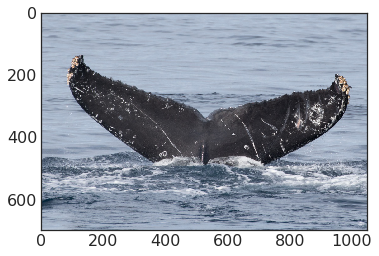

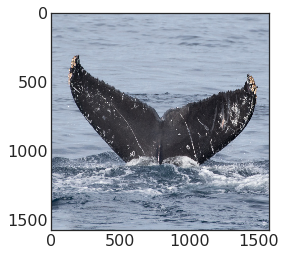

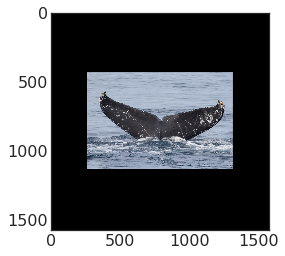

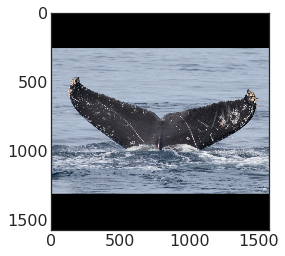

In [242]:
imga, imgb, labs = gen_random_batch_img_names(same_train, diff_train, 8, (512, 512, 3))

print(skimage.io.imread('../train/'+imga[0]).shape)
sam0 = skimage.io.imread('../train/'+imga[0])
sama = resize(skimage.io.imread('../train/'+imga[0]), (1575, 1575, 3))
samb = biggenate_zero_pad(skimage.io.imread('../train/'+imga[0]), (1575, 1575, 3))/255
samc = resize_w_aspect_ratio(skimage.io.imread('../train/'+imga[0]), 1575)

# print(sama.max(), sama.min())
# difa = skimage.io.imread('../train/'+imga[-1])
# difb = skimage.io.imread('../train/'+imgb[-1])

plt.imshow(sam0); plt.show()
plt.imshow(sama); plt.show()
plt.imshow(samb); plt.show()
plt.imshow(samc); plt.show()

# plt.imshow(difa); plt.show()
# plt.imshow(difb); plt.show()

In [234]:
samb.min(), samb.max(), samc.min(), samc.max()

(0.0, 0.9803921568627451, 0.019768747193550557, 0.9938491618021258)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


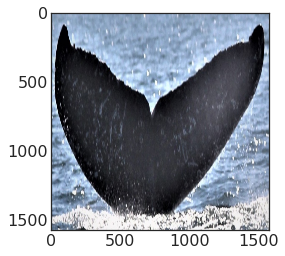

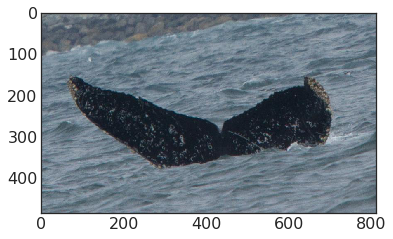

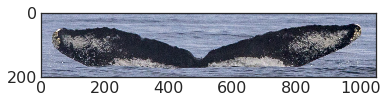

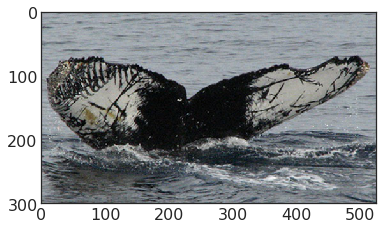

In [156]:
imga, imgb, labs = gen_random_batch_img_names(same_train, diff_train, 8, (512, 512, 3))

sama = resize(skimage.io.imread('../train/'+imga[0]), (1575, 1575, 3))
samb = skimage.io.imread('../train/'+imgb[0])

difa = skimage.io.imread('../train/'+imga[-1])
difb = skimage.io.imread('../train/'+imgb[-1])

plt.imshow(sama); plt.show()
plt.imshow(samb); plt.show()

plt.imshow(difa); plt.show()
plt.imshow(difb); plt.show()

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


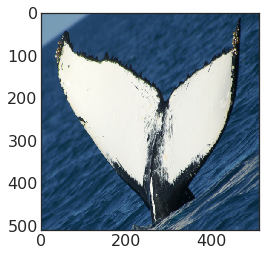

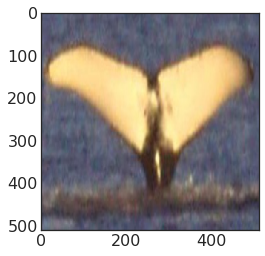

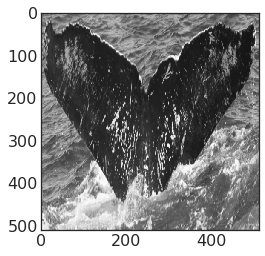

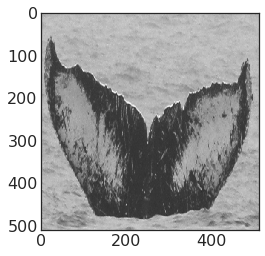

In [159]:
imga, imgb, labs = gen_random_batch(same_train, diff_train, 8, (512, 512, 3))

plt.imshow(imga[0]); plt.show()
plt.imshow(imgb[0]); plt.show()

plt.imshow(imga[-1]); plt.show()
plt.imshow(imgb[-1]); plt.show()

In [131]:
imga, imgb, labs = gen_random_batch_resize_scale(same_train, diff_train, 8, (512, 512, 3))

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


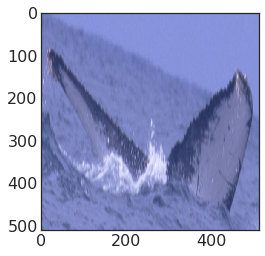

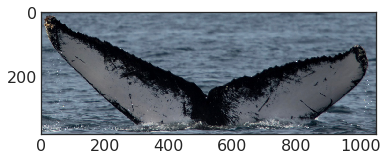

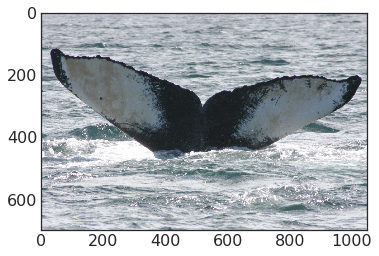

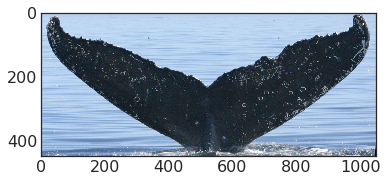

In [134]:
sama = resize(skimage.io.imread('../train/'+imga[0]), (512, 512,3))
samb = skimage.io.imread('../train/'+imgb[0])

difa = skimage.io.imread('../train/'+imga[-1])
difb = skimage.io.imread('../train/'+imgb[-1])

plt.imshow(sama); plt.show()
plt.imshow(samb); plt.show()

plt.imshow(difa); plt.show()
plt.imshow(difb); plt.show()

In [139]:
sama.min()*255, sama.max()*255

(36.136436462402436, 255.0)

In [127]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [128]:
x_train.max()

255

## Construct the Siamese Network

In [16]:
# initial_model = ResNet50(weights='imagenet', include_top=False)
# input = Input(shape=(480, 720, 3), name='image_input')
# x = Flatten()(initial_model(input))
# x = Dense(200, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Dense(1)(x)
# model = Model(inputs=input, outputs=x)
# model.compile(loss='mse', optimizer='adam')

In [17]:
def get_abs_diff(vects):
    x, y = vects
    return K.abs(x - y)  

In [17]:
# FC_dropout = 0.2
# # input_shape = (224, 224, 3)
# input_shape = (512, 512, 3)

# ### Create the input layer ###
# myinput = Input(shape=input_shape)

# ### First create the base_model for transferring ###
# base_model = VGG16(weights='imagenet', include_top=False)

# ### Get the convolutional output out, extract to an n-dimensional embedding vector ###
# x = Flatten()(base_model(myinput))
# x = Dense(1024, activation='relu')(x)
# x = Dropout(FC_dropout)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(FC_dropout)(x)

# model_proto = Model(inputs=myinput, outputs=x)

# left_input = Input(shape=input_shape)
# right_input = Input(shape=input_shape)

# left_proto = model_proto(left_input)
# right_proto = model_proto(right_input)

# # comb = Subtract()([left_proto,right_proto])

# comb = Lambda(get_abs_diff)([left_proto,right_proto])

# comb = Dense(1, activation='sigmoid')(comb)

# model_siam = Model(inputs=[left_input, right_input], output=[comb])
# model_siam.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [270]:
FC_dropout = 0.2
# input_shape = (224, 224, 3)
input_dim = 256
input_shape = (input_dim, input_dim, 3)
# input_shape = (None, None, 3)

### Create the input layer ###
myinput = Input(shape=input_shape)

### First create the base_model for transferring ###
base_model = VGG16(weights='imagenet', include_top=False)

### Get the convolutional output out, extract to an n-dimensional embedding vector ###
x = base_model(myinput)
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)#(base_model(myinput))
x = Dense(128, activation='relu')(x)
x = Dropout(FC_dropout)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(FC_dropout)(x)

model_proto = Model(inputs=myinput, outputs=x)

left_input = Input(shape=input_shape)
right_input = Input(shape=input_shape)

left_proto = model_proto(left_input)
right_proto = model_proto(right_input)

# combined_features = concatenate([left_proto, right_proto], name = 'merge_features')
# combined_features = Dense(16, activation = 'linear')(combined_features)
# combined_features = BatchNormalization()(combined_features)
# combined_features = Activation('relu')(combined_features)
# combined_features = Dense(4, activation = 'linear')(combined_features)
# combined_features = BatchNormalization()(combined_features)
# combined_features = Activation('relu')(combined_features)
# combined_features = Dense(1, activation = 'sigmoid')(combined_features)

# comb = Subtract()([left_proto,right_proto])

# combined_features = Lambda(get_abs_diff)([left_proto,right_proto])

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([left_proto, right_proto])

comb = Dense(1, activation='sigmoid')(L1_distance)
# comb = Dense(1, activation='sigmoid')(combined_features)

model_siam = Model(inputs=[left_input, right_input], output=[comb])

optimizer = Adam(0.00006)
optimizer = Adam()

model_siam.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['mae'])

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [248]:
model_siam.layers

In [249]:
model_proto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
Total params: 14,780,352
Trainable params: 14,780,352
Non-trainable params: 0
_________________________________________________________________


In [250]:
model_siam.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_15 (Model)                (None, 128)          14780352    input_37[0][0]                   
                                                                 input_38[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 128)          0           model_15[1][0]                   
          

In [272]:
valid_a, valid_b, valid_sim = gen_random_batch_resize_preserve_AR(same_val, diff_val, 16, input_dim)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [273]:
loss_history = model_siam.fit_generator(siam_gen_resize_preserve_AR(same_train, diff_train, 32, input_dim), 
                               steps_per_epoch = 10,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10


/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10/10 [==============================] - 18s 2s/step - loss: 0.8388 - mean_absolute_error: 0.4994 - val_loss: 0.6982 - val_mean_absolute_error: 0.5025
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 0.7191 - mean_absolute_error: 0.5030 - val_loss: 0.6941 - val_mean_absolute_error: 0.5005
Epoch 3/10
10/10 [==============================] - 15s 2s/step - loss: 0.6922 - mean_absolute_error: 0.4995 - val_loss: 0.6635 - val_mean_absolute_error: 0.4805
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.7374 - mean_absolute_error: 0.4984 - val_loss: 0.6936 - val_mean_absolute_error: 0.5002
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.6937 - mean_absolute_error: 0.5002 - val_loss: 0.6897 - val_mean_absolute_error: 0.4982
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 0.6944 - mean_absolute_error: 0.4960 - val_loss: 0.6932 - val_mean_absolute_error: 0.5000
Epoch 7/10
10/10 [=====================

In [17]:
FC_dropout = 0.2
input_shape = (512, 512, 3)

left_input = Input(input_shape)
right_input = Input(input_shape)

### Import the pretrained model ###
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

left_model = base_model(left_input)
right_model = base_model(right_input)

glavg1 = GlobalAveragePooling2D()

dense1 = Dense(1024, activation='relu')
dropo1 = Dropout(FC_dropout)
dense2 = Dense(512, activation='relu')
dropo2 = Dropout(FC_dropout)

xl = left_model.output
xr = right_model.output

xl = glavg1(xl)
xl = dense1(xl)
xl = dropo1(xl)
xl = dense2(xl)
xl = dropo2(xl)

xr = glavg1(xr)
xr = dense1(xr)
xr = dropo1(xr)
xr = dense2(xr)
xr = dropo2(xr)

x = K.abs(xl-xr)

# x = base_model.output
# base_model.
# # Notice that we did not include the top of the neural network, which is the set of densely connected
# # layers that where used to convert the output of the convolutional layers that find image features
# # into the 1000 classes of the ImageNet dataset

# ### We need a normalization layer here to get the model output in a form we can send to a dense layer $$$
# x = GlobalAveragePooling2D()(x)
# # x = GlobalMaxPooling2D()(x)

# # let's add fully-connected layers, using dropout as a way to keep the network
# # from overfitting to the training data (regularization)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.2)(x)

model = Model(inputs=[left_input, right_input], outputs=x)

ValueError: Variable bn_conv1_5/moving_mean/biased already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/opt/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1004, in moving_average_update
    x, value, momentum, zero_debias=True)
  File "/opt/anaconda/lib/python3.6/site-packages/keras/layers/normalization.py", line 193, in call
    self.momentum),
  File "/opt/anaconda/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)


In [13]:
x.summary()

AttributeError: 'Tensor' object has no attribute 'summary'